# Análise de Séries Temporais com métodos estatísticos

## Índices

1. **Introdução**
1. **Leitura e tratamento**
1. **Análise Exploratória**
1. **Transformações**
1. **Predição**
1. **Reversões**
1. **Comparações e avalições**
    - **Conclusão**

## introdução

O presente trabalho tem como objetivo estabelecer uma linha de base (baseline) por meio da aplicação de métodos estatísticos, visando fornecer um ponto de referência para futuras comparações. Essa baseline servirá como fundamento para avaliar e comparar de forma objetiva os resultados obtidos com diferentes configurações ao longo do desenvolvimento do projeto, particularmente no contexto da Neuro-Evolução.

**dataSet**
-   Obtido a partir do site <a href="https://gml.noaa.gov/">gml.noaa.gov</a>

**dados**
-   Os dados analisados são referentes às <a href="https://gml.noaa.gov/ccgg/trends/gl_data.html">Tendências do dióxido de carbono atmosférico</a>, cobrindo o período de 1979 à 2024.
-   As medições estão na escala de partes por milhão (ppm). Por exemplo, uma concentração de 0,000400 corresponde a 400 ppm.
    -   **Mais especificamente:** a medição representa uma fração molar de CO₂ no ar seco, ou seja, o número de moléculas de dióxido de carbono dividido pelo número total de moléculas no ar (incluindo o próprio CO₂), após a remoção do vapor d’água.

### Download e importação de bibliotecas

In [516]:
# pip install pandas numpy scipy matplotlib seaborn statsmodels pmdarima arch scikit-learn

In [517]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection
from arch import arch_model
from scipy.stats import boxcox
from scipy.special import boxcox, inv_boxcox
from scipy.stats import shapiro
from scipy.stats import zscore

## Leitura e Tratamento<a id="pre_processamento"></a>

In [518]:
def ler_csv(caminho_arquivo:str, average_only:bool=False):
    # Leitura do arquivo adaptado (remoção de comentários)
    dataSet = pd.read_csv(caminho_arquivo)
    
    # Remove coluna 'decimal' se existir
    if 'decimal' in dataSet.columns:
        dataSet = dataSet.drop(columns=['decimal'])
    
    # Formatação da coluna de data
    dataSet['data'] = pd.to_datetime(dataSet['year'].astype(str) + '-' + dataSet['month'].astype(str))
    
    if average_only:
        # Mantém apenas 'data' e 'average'
        dataSet = dataSet.set_index('data')['average']
    else:
        # Remove 'year' e 'month', mantendo todas as outras colunas exceto essas
        colunas = ['data'] + [col for col in dataSet.columns if col not in ['data', 'year', 'month']]
        dataSet = dataSet[colunas]
    
    return dataSet

full_data_set = ler_csv('dataSet.csv')
data_set = ler_csv('dataSet.csv', average_only=True)

In [519]:
full_data_set

,data,average,average_unc,trend,trend_unc
0,1979-01-01,336.56,0.11,335.92,0.10
1,1979-02-01,337.29,0.09,336.26,0.10
2,1979-03-01,337.88,0.11,336.51,0.10
3,1979-04-01,338.32,0.13,336.72,0.11
4,1979-05-01,338.26,0.04,336.71,0.11
...,...,...,...,...,...
547,2024-08-01,420.19,0.10,423.08,0.06
548,2024-09-01,420.50,0.10,423.35,0.06
549,2024-10-01,422.32,0.10,423.81,0.06
550,2024-11-01,424.07,0.10,424.16,0.06


In [520]:
full_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         552 non-null    datetime64[ns]
 1   average      552 non-null    float64       
 2   average_unc  552 non-null    float64       
 3   trend        552 non-null    float64       
 4   trend_unc    552 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 21.7 KB


In [521]:
data_set

data
1979-01-01    336.56
1979-02-01    337.29
1979-03-01    337.88
1979-04-01    338.32
1979-05-01    338.26
               ...  
2024-08-01    420.19
2024-09-01    420.50
2024-10-01    422.32
2024-11-01    424.07
2024-12-01    425.19
Name: average, Length: 552, dtype: float64

In [522]:
data_set.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 552 entries, 1979-01-01 to 2024-12-01
Series name: average
Non-Null Count  Dtype  
--------------  -----  
552 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


## Análise Exploratória

### Funções auxiliares

#### Gráficos

##### Histograma

In [523]:
def plotHistogram(data, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    sns.histplot(data, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### Gráfico de Linha

In [524]:
def plotLine(data, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    plt.plot(data.index, data.values, linestyle='-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### BloxPlot

In [525]:
def plotBoxplot(data, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    sns.boxplot(x=data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### Gráfico de Dispersão

In [526]:
def plotScatter(datax, datay, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    sns.scatterplot(x=datax, y=datay)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### Gráfico de Área

In [527]:
def plotArea(data, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    plt.fill_between(data.index, data.values, alpha=0.5)
    plt.plot(data.index, data.values, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### Gráfico Q-Q

In [528]:
def graficoQQ(data, title=None):
    plt.figure(figsize=(20, 10))
    sm.qqplot(data, line='s')
    plt.title(title)
    plt.show()

##### Decomposição

In [529]:

def plotDecomposicao(data, model='additive', period=12, title=None, figsize=(20, 10)):

    # Realiza a decomposição
    decomposition = seasonal_decompose(data, model=model, period=period)
    
    # Cria uma figura para plotar os componentes
    plt.figure(figsize=figsize)
    
    # Série Original
    plt.subplot(4, 1, 1)
    plt.plot(data, label='Original')
    plt.legend(loc='upper left')
    plt.title(title)
    
    # Tendência
    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Tendência', color='orange')
    plt.legend(loc='upper left')
    
    # Sazonalidade
    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Sazonalidade', color='green')
    plt.legend(loc='upper left')
    
    # Resíduos
    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Resíduos', color='red')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

#### Estatística

##### AdFuller

In [530]:
def adfullerTest(data):
    adFUllerTest = adfuller(data)
    print(f"Estatística do teste ADF: {adFUllerTest[0]}")
    print(f"Valor-p: {adFUllerTest[1]:.16f}")
    print("Valores críticos:")
    for key, value in adFUllerTest[4].items():
        print(f"   {key}: {value}")

    # Interpretação
    if adFUllerTest[1] <= 0.0005:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

##### Kolmogorov-Smirnov

In [531]:
def kolmogorovTest(data):
    ks_test = stats.kstest(data, 'norm')
    
    print('\nTeste de Kolmogorov-Smirnov')
    print(f'Estatística: {ks_test.statistic:.8f}')
    print(f'Valor-p: {ks_test.pvalue:.8f}')
    if ks_test.pvalue < 0.05:
        print('Rejeita a hipótese nula (os dados não seguem uma distribuição normal)')
    else:
        print('Não rejeita a hipótese nula (os dados seguem uma distribuição normal)')

##### Anderson-Darling

In [532]:
def andersonTest(data):
    ad_test = stats.anderson(data, dist='norm')
    
    print('\nTeste de Anderson-Darling')
    print(f'Estatística: {ad_test.statistic:.8f}')
    print('Valores Críticos:', [f'{cv:.8f}' for cv in ad_test.critical_values])
    print('Níveis de Significância:', ad_test.significance_level)
    
    for i in range(len(ad_test.critical_values)):
        sl, cv = ad_test.significance_level[i], ad_test.critical_values[i]
        if ad_test.statistic > cv:
            print(f'Para um nível de significância de {sl}%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)')
        else:
            print(f'Para um nível de significância de {sl}%, não rejeita a hipótese nula (os dados seguem uma distribuição normal)')

##### Método IQR

In [533]:
def detectar_outliers_iqr(series: pd.Series, fator: float = 1.5) -> pd.Series:
    """ 
        Retorna um series com valores booleanos
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - fator * IQR
    limite_superior = Q3 + fator * IQR

    return (series < limite_inferior) | (series > limite_superior)

##### Método Z-Score

In [534]:
def detectar_outliers_zscore(series: pd.Series, limite: float = 2.5) -> pd.Series:
    """ 
        Retorna um series com valores booleanos
    """
    z_scores = zscore(series)
    return abs(z_scores) > limite

### Auto correlação e Auto Correlação Parcial

In [535]:
def plotAutoCorrelation(data):
    plt.figure(figsize=(16, 8))
    plot_acf(data, ax=plt.gca(), lags=50)
    plt.title('Função de Autocorrelação (ACF)')
    plt.show()

In [536]:
def plotPartialAutoCorrelation(data):
    plt.figure(figsize=(16, 8))
    plot_pacf(data, ax=plt.gca(), lags=50)
    plt.title('Função de Autocorrelação Parcial (PACF)')
    plt.show()

### Análise dos dados

#### Análise visual

##### Histogram & Line

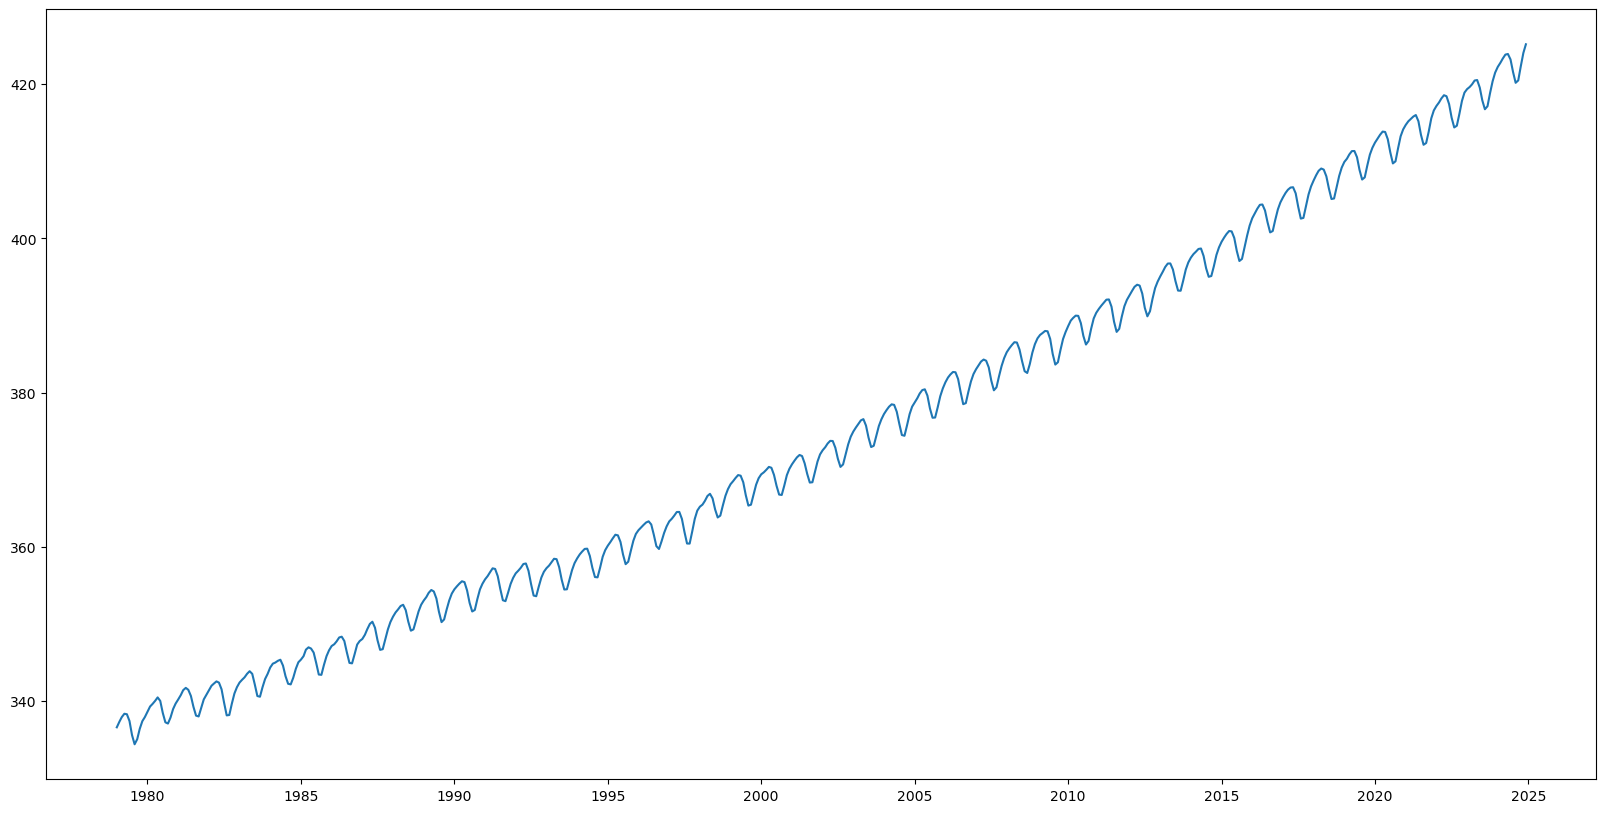

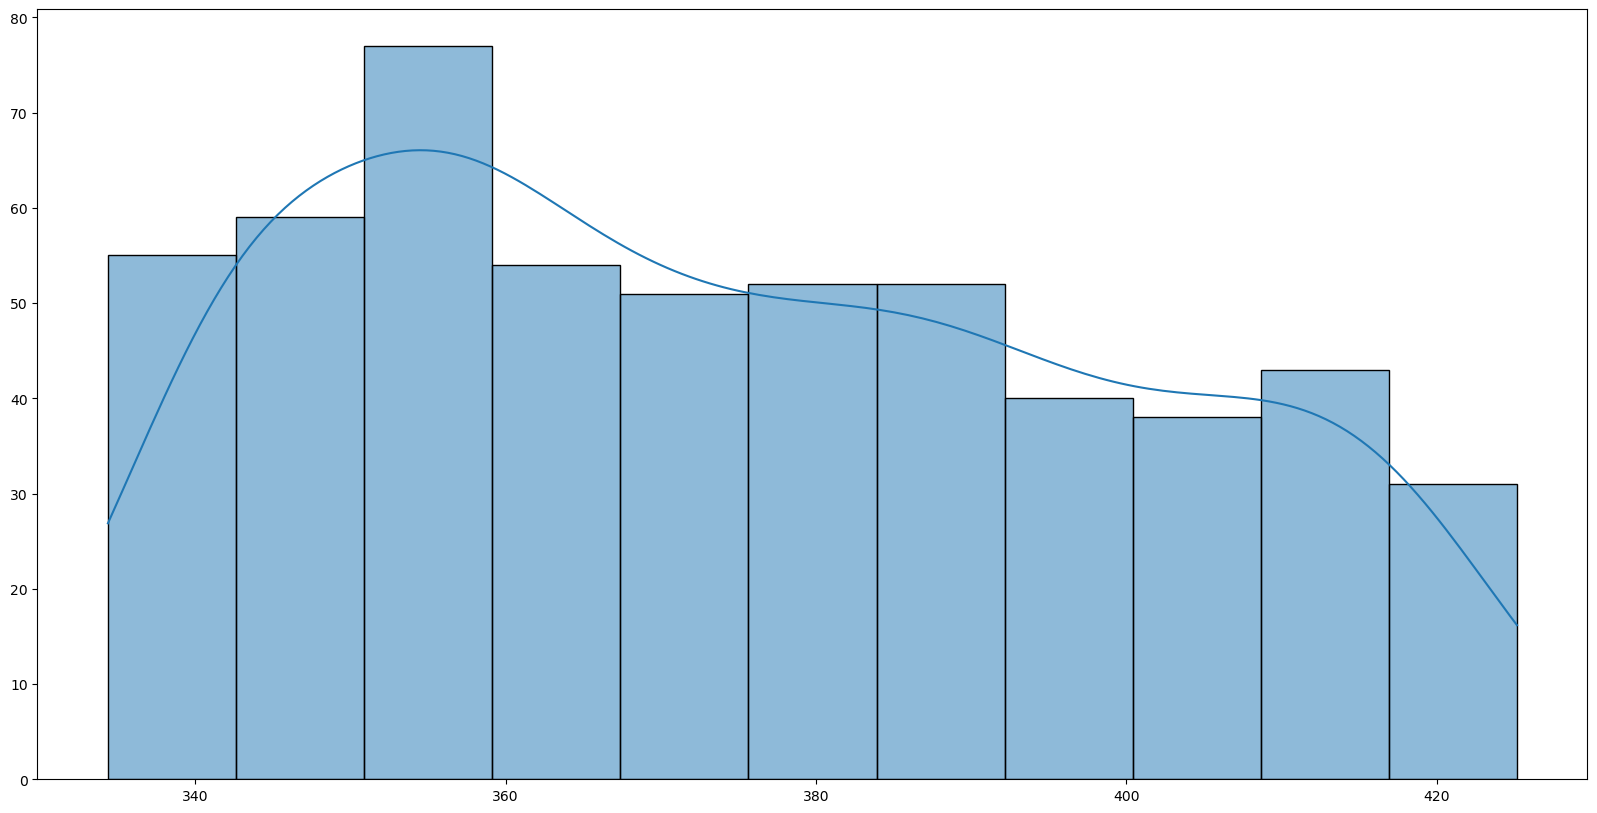

In [537]:
plotLine(data_set)
plotHistogram(data_set)

##### Decomposition

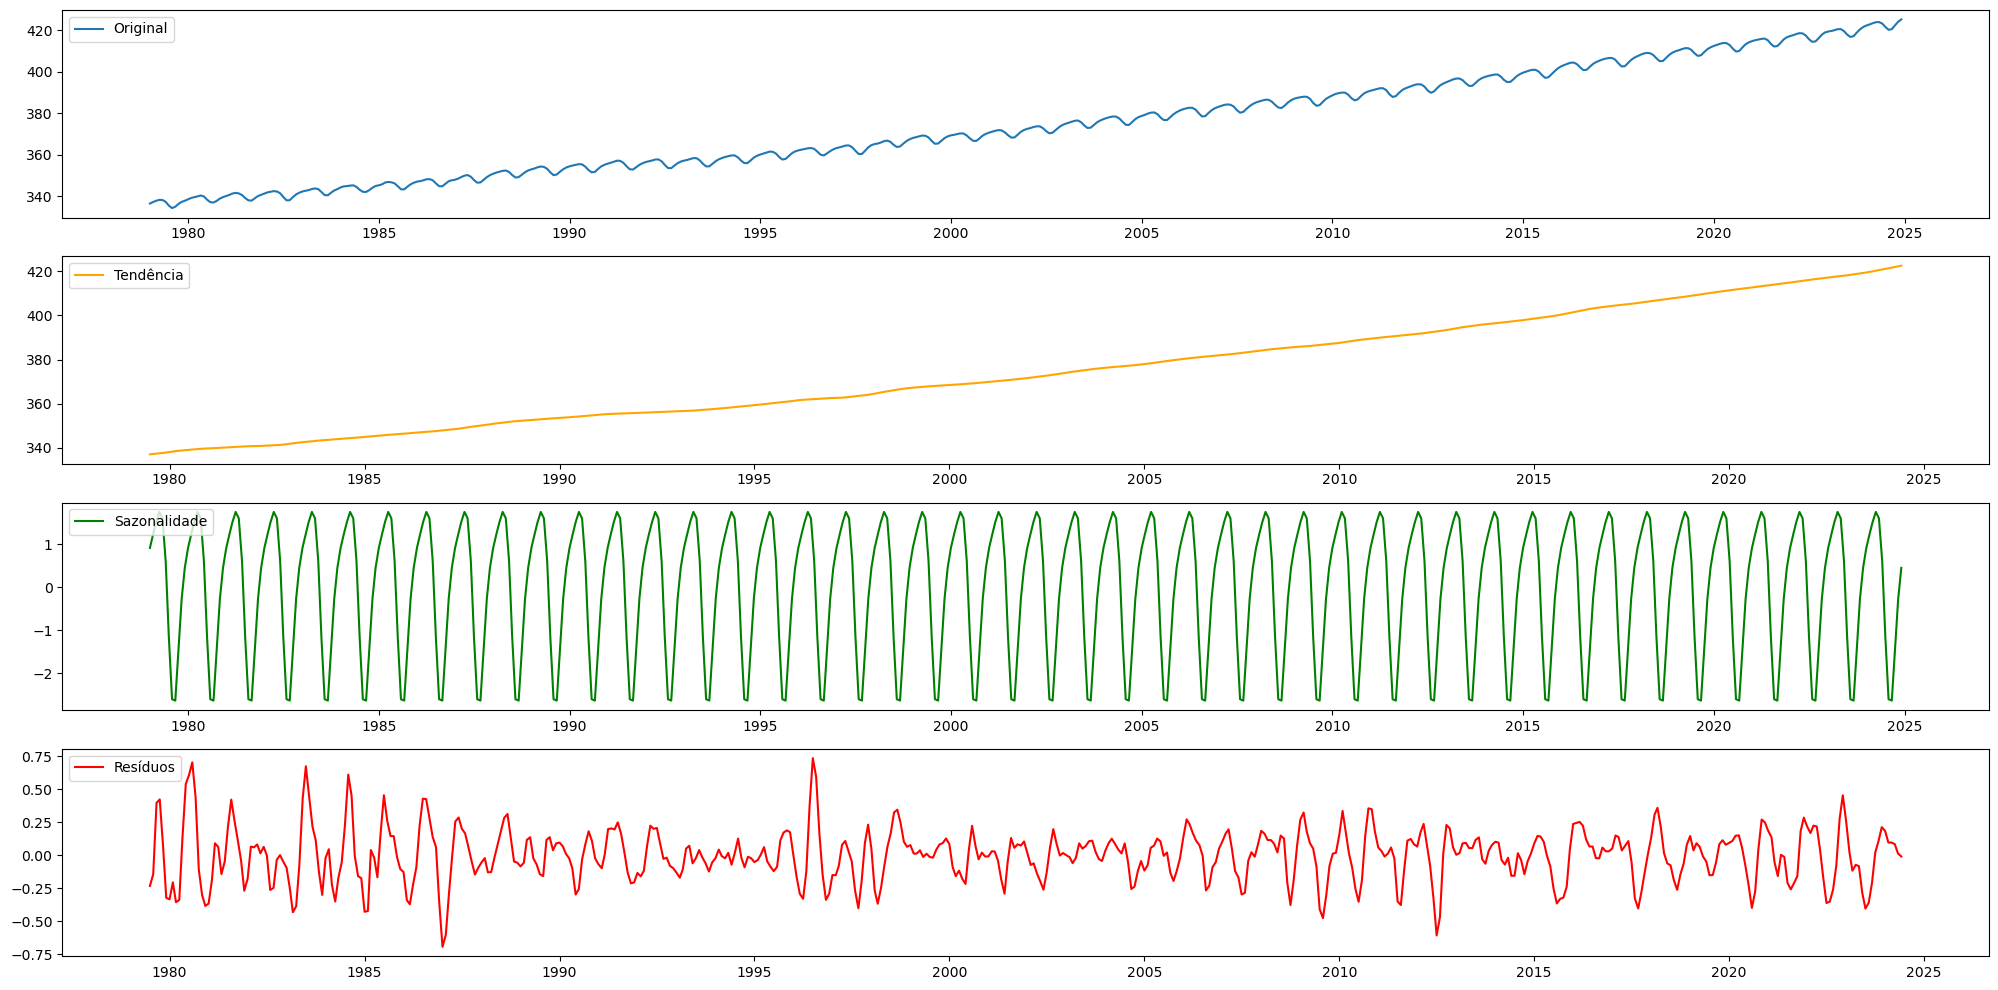

In [538]:
plotDecomposicao(data_set)

Com estes gráficos percebo:
-   Não há outliers
-   Tendência bem definida linear
-   comportamento ciclico

##### PACF & ACF

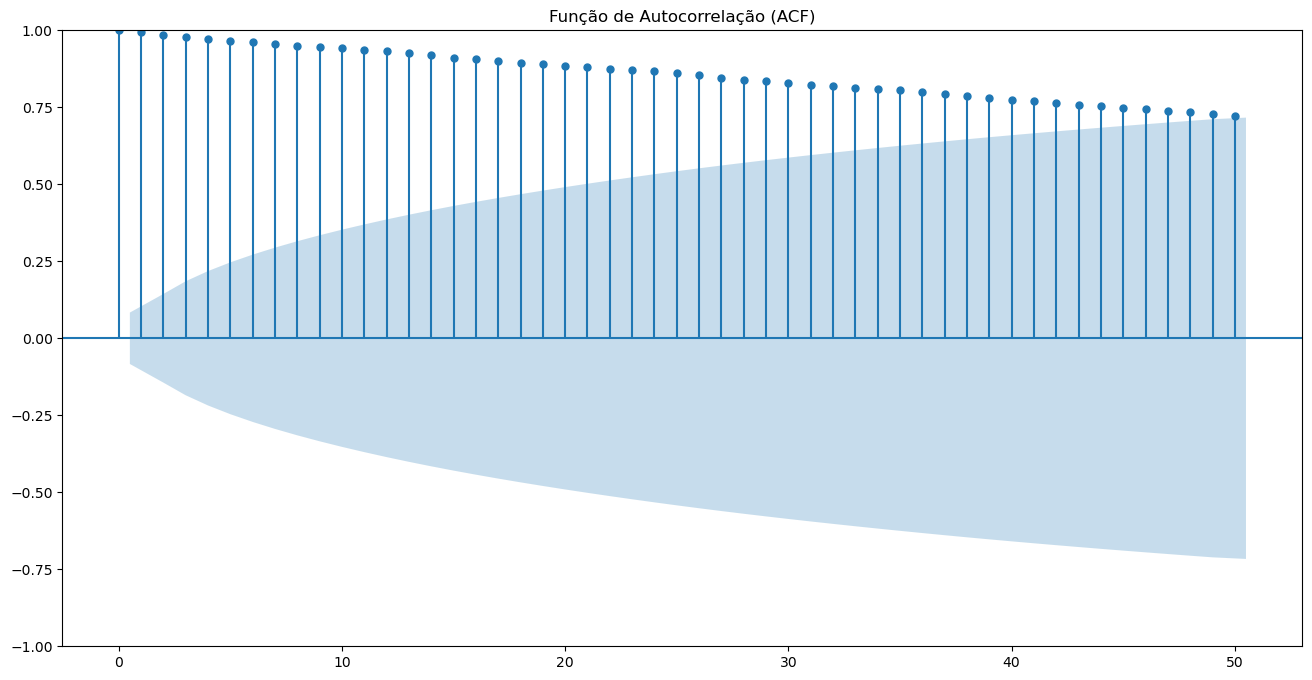

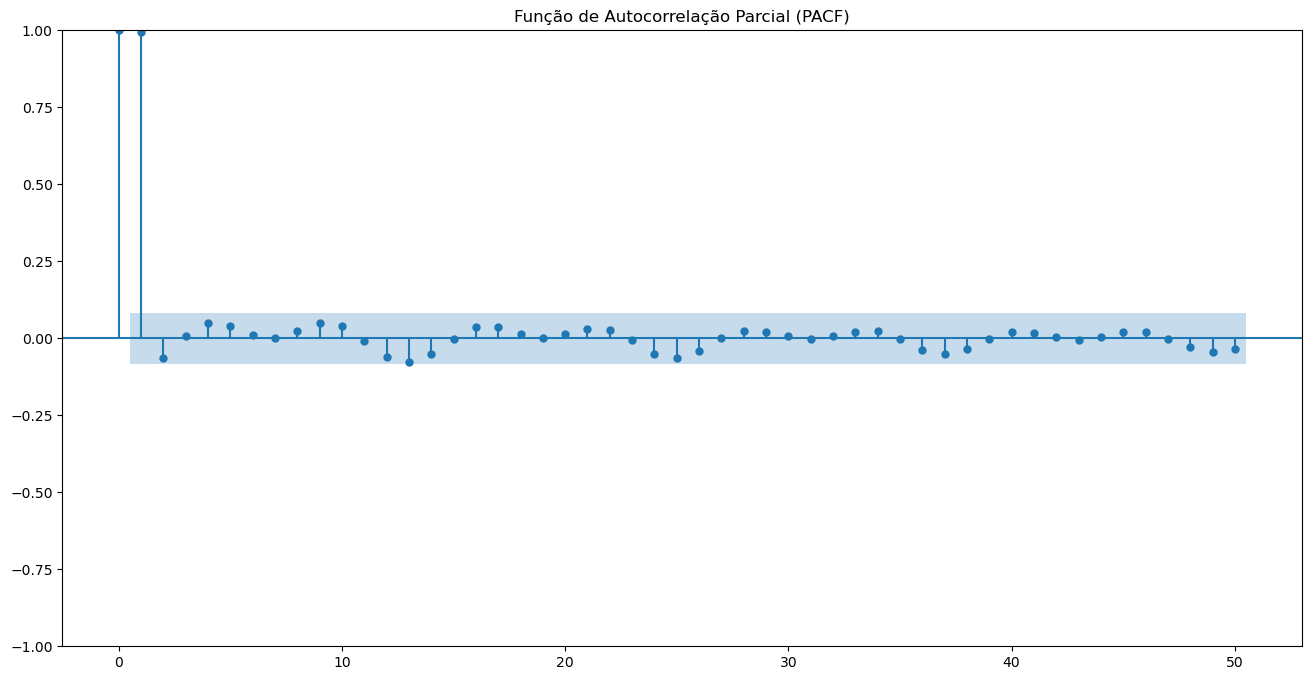

In [539]:
plotAutoCorrelation(data_set)
plotPartialAutoCorrelation(data_set)

#### Análise estatística

In [540]:
adfullerTest(data_set)
andersonTest(data_set)
kolmogorovTest(data_set)

Estatística do teste ADF: 4.648385021622501
Valor-p: 1.0000000000000000
Valores críticos:
   1%: -3.442701754304053
   5%: -2.866988120523906
   10%: -2.5696716542766693
A série não é estacionária.

Teste de Anderson-Darling
Estatística: 7.42896891
Valores Críticos: ['0.57200000', '0.65100000', '0.78100000', '0.91100000', '1.08400000']
Níveis de Significância: [15.  10.   5.   2.5  1. ]
Para um nível de significância de 15.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 10.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 5.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 2.5%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 1.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)

Teste de Kolmogorov-Smirnov
Estatística: 1.00000000
Valor

In [541]:
a = detectar_outliers_iqr(data_set)
a_list = []
for valor in a:
    if valor == True:
        a_list.append(valor)

print(a_list)

[]


In [ ]:
b = detectar_outliers_zscore(data_set)

b_list = []
for valor in b:
    if valor == True:
        b_list.append(valor)

print(b_list)

[]


## Transformações

**Separação dos dados**

In [ ]:
# Calcula o índice de corte
cutoff = int(len(data_set) * 0.8)

# Divide a série em treino e teste
train = data_set.iloc[:cutoff]
test = data_set.iloc[cutoff:]

### Diferenciação

336.56


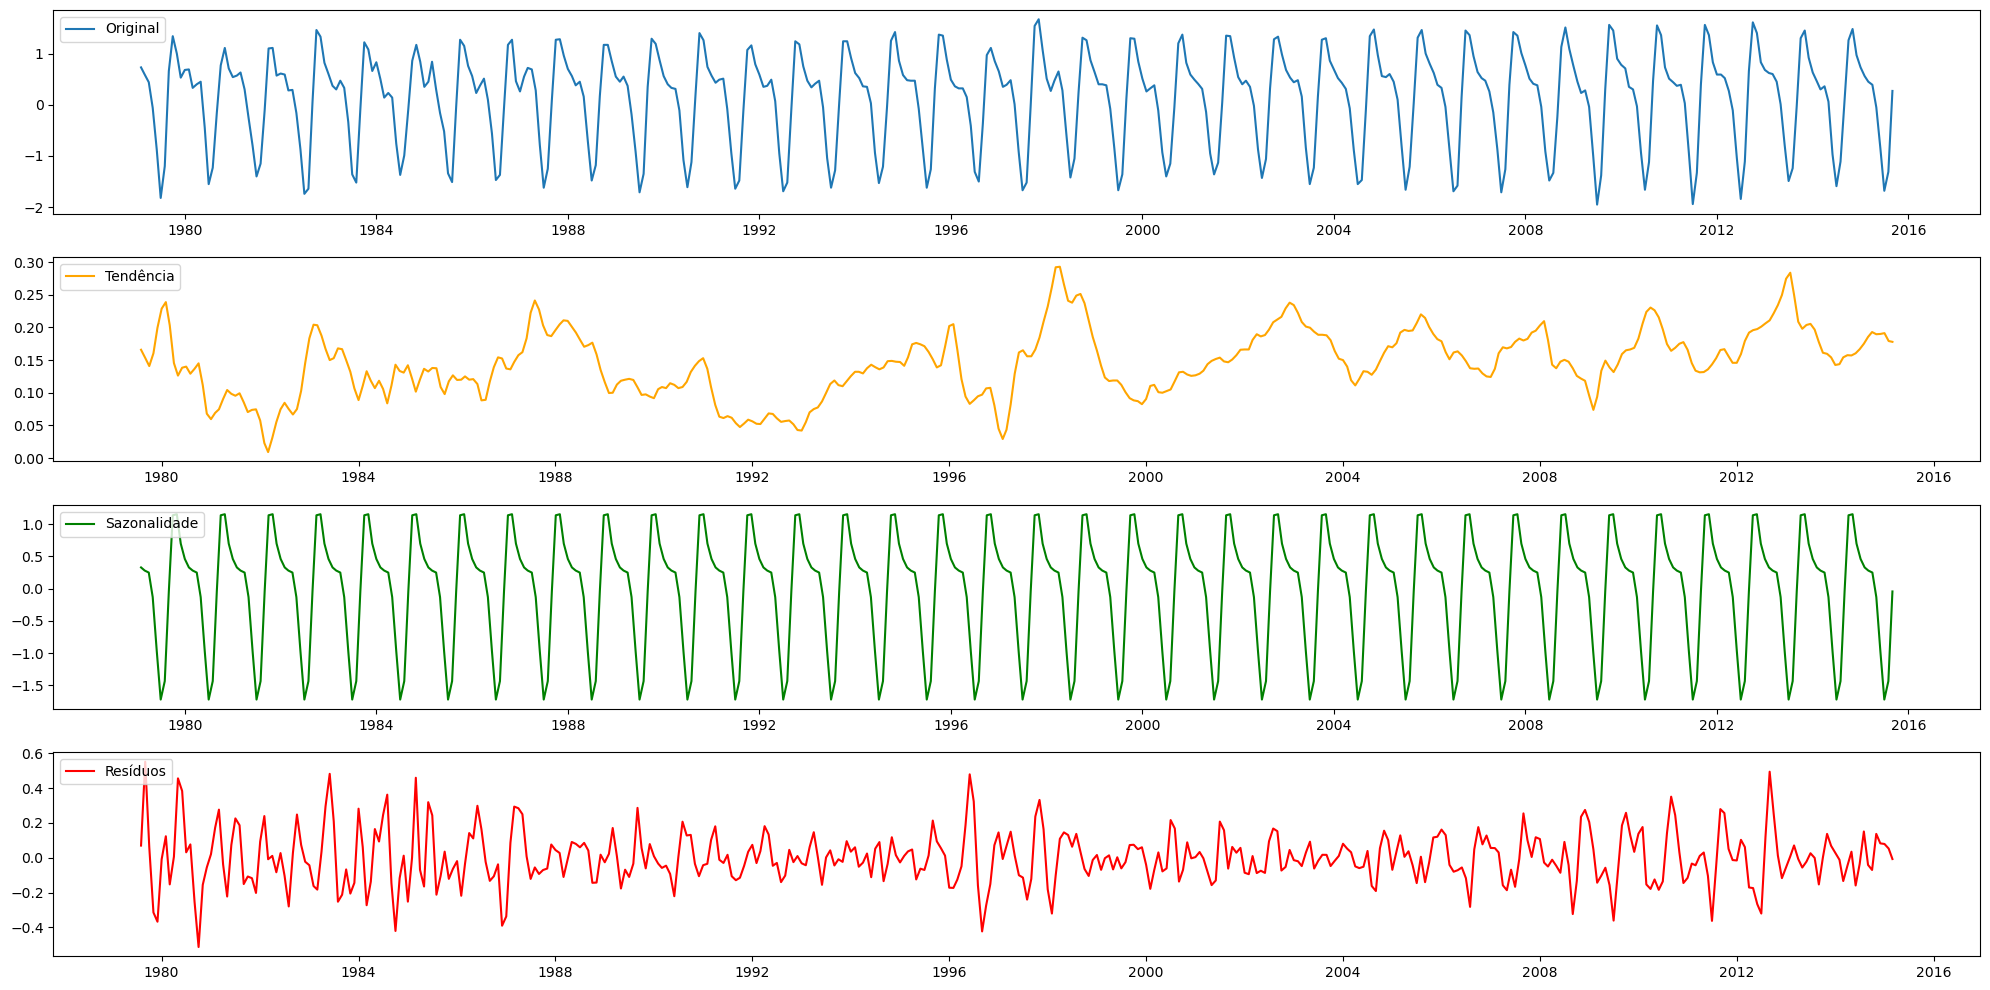

In [ ]:
first_value = train.iloc[0]
diff_data = train.diff().dropna()

print (first_value)
plotDecomposicao(diff_data)

##### Estatísticas

Estatística do teste ADF: -4.6219772505580865
Valor-p: 0.0001176430802900
Valores críticos:
   1%: -3.445978550826048
   5%: -2.8684297456394874
   10%: -2.570440005247093
A série é estacionária.

Teste de Anderson-Darling
Estatística: 12.91873317
Valores Críticos: ['0.57100000', '0.65000000', '0.78000000', '0.91000000', '1.08200000']
Níveis de Significância: [15.  10.   5.   2.5  1. ]
Para um nível de significância de 15.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 10.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 5.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 2.5%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 1.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)

Teste de Kolmogorov-Smirnov
Estatística: 0.20484084
Valor-

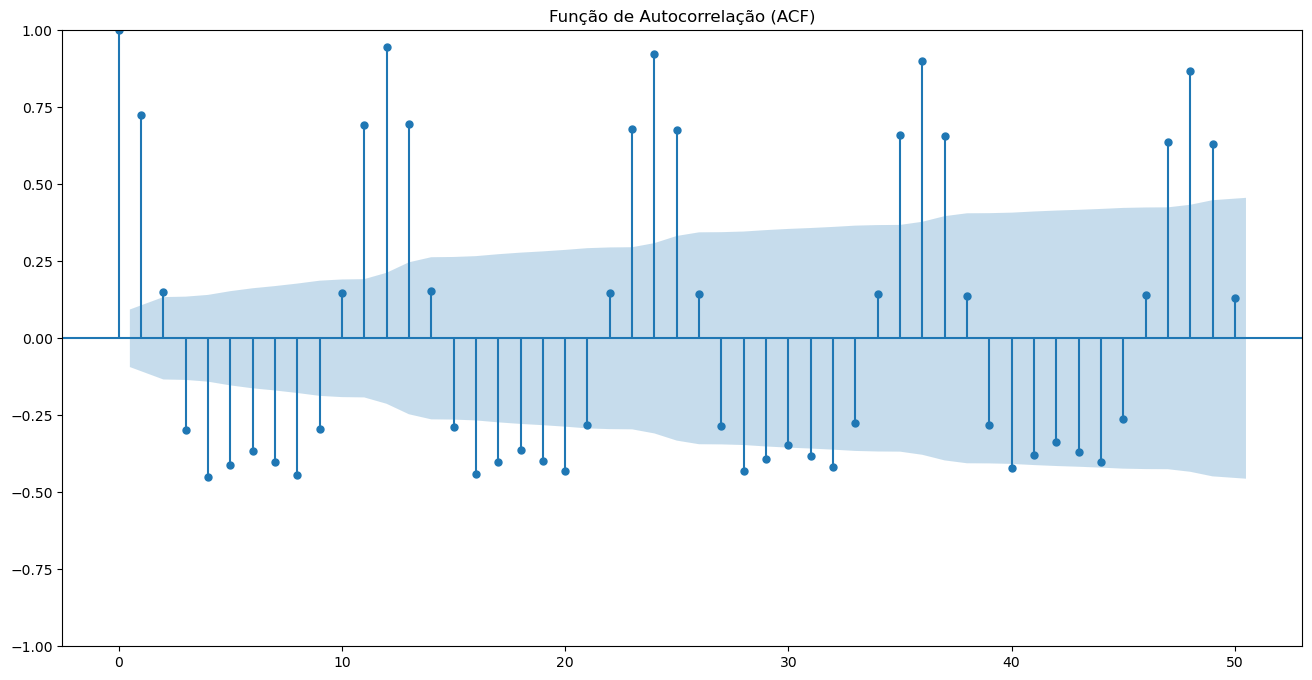

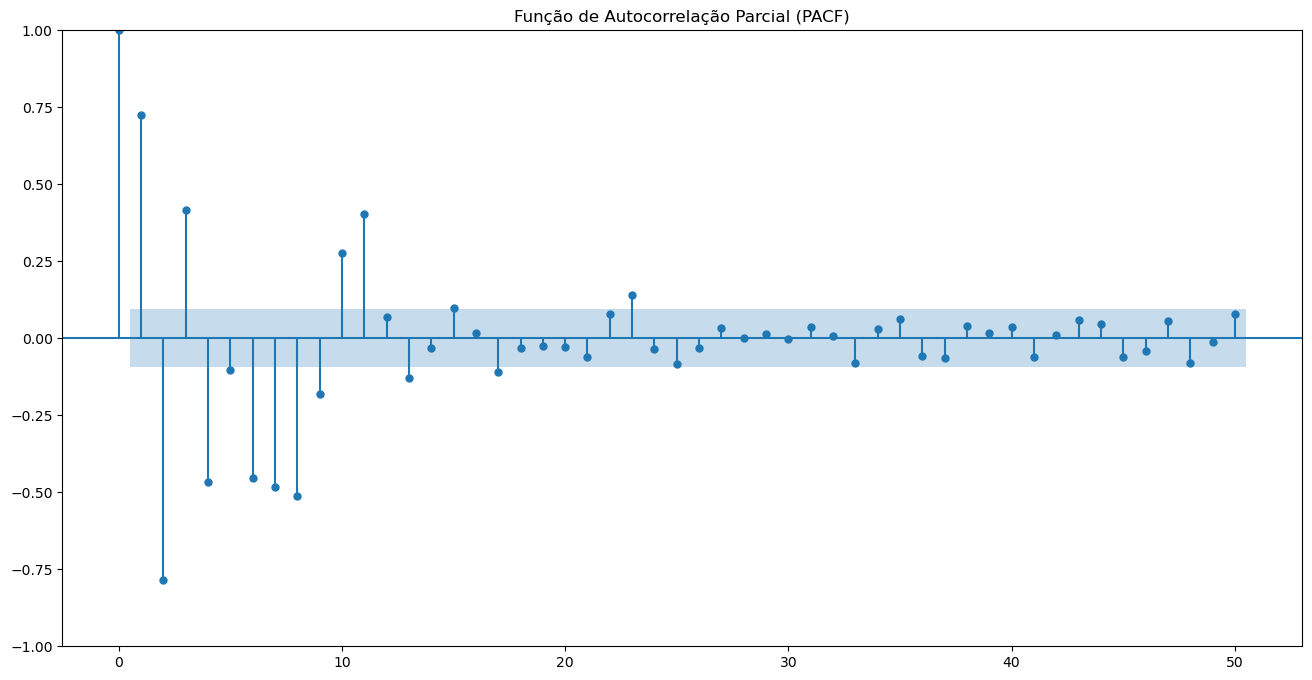

In [ ]:
adfullerTest(diff_data)
andersonTest(diff_data)
kolmogorovTest(diff_data)
plotAutoCorrelation(diff_data)
plotPartialAutoCorrelation(diff_data)

#### Testando uma segunda diferenciação

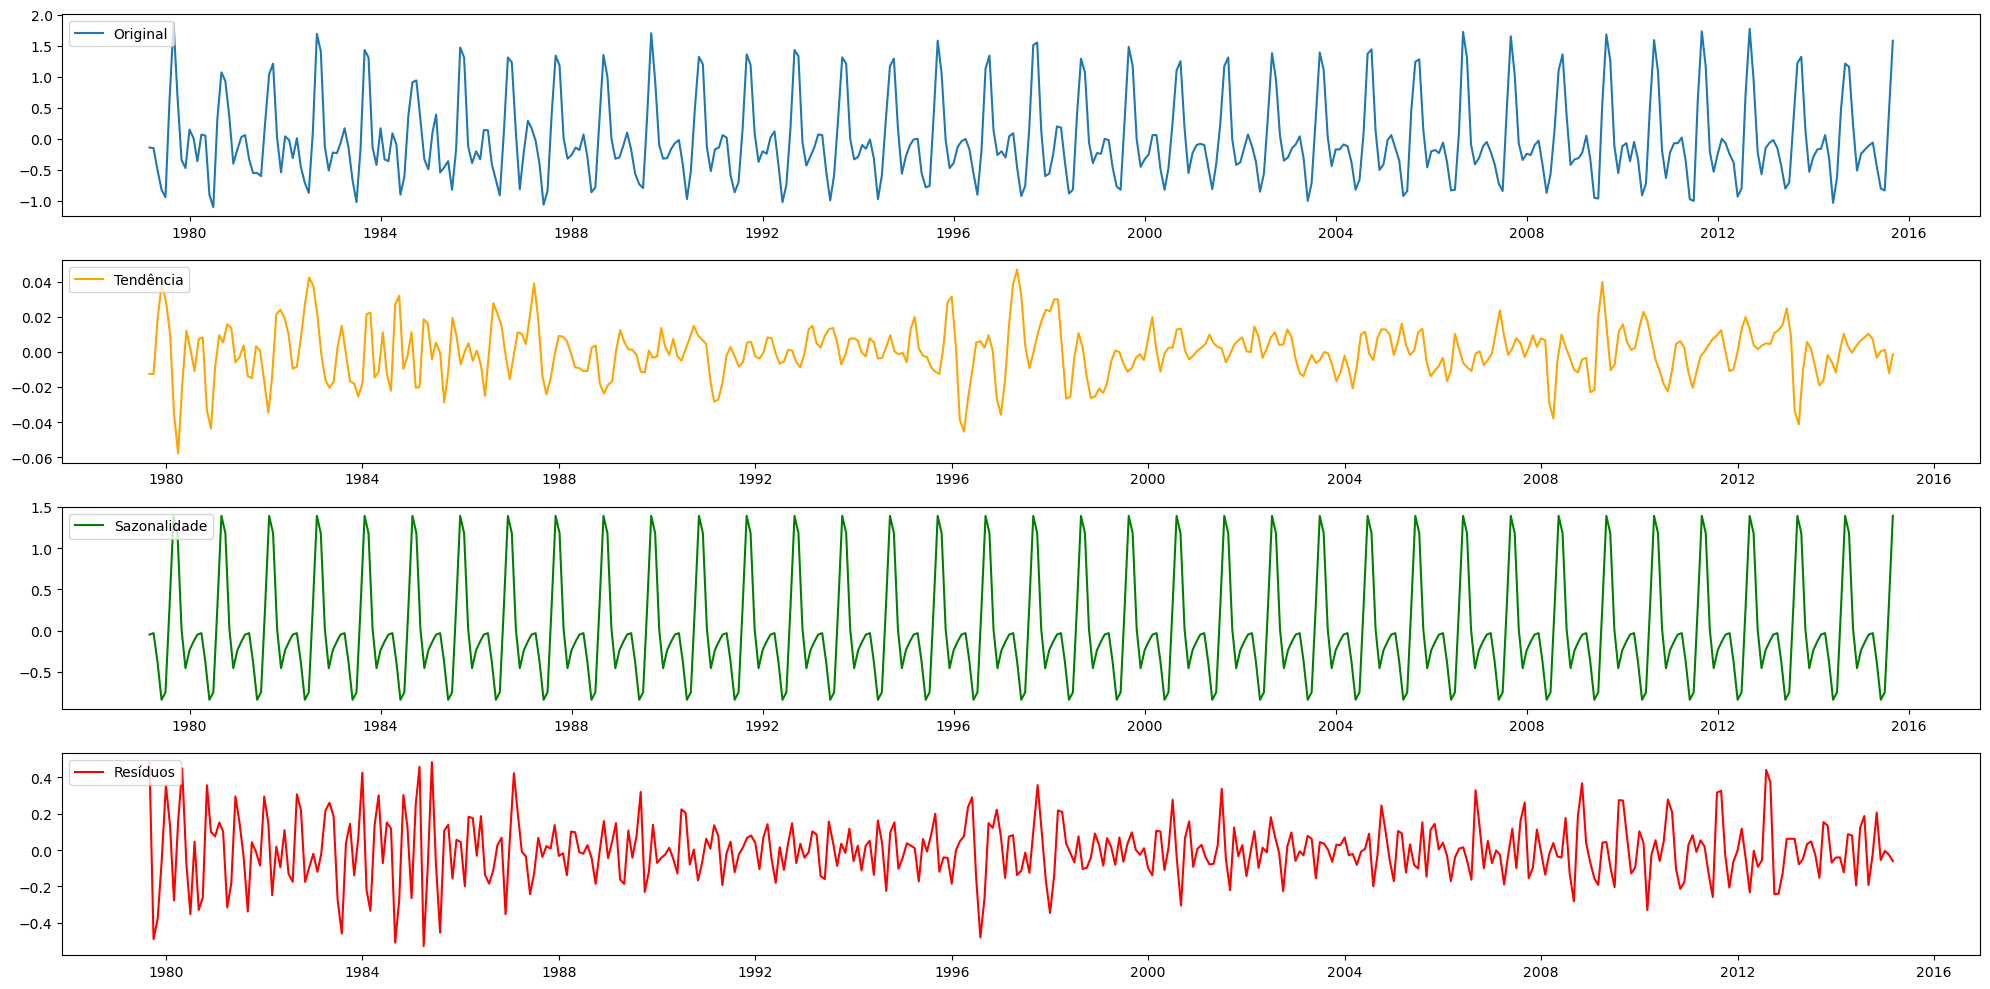

Estatística do teste ADF: -5.8815598983078115
Valor-p: 0.0000003069785912
Valores críticos:
   1%: -3.4460159927788574
   5%: -2.868446209372638
   10%: -2.570448781179138
A série é estacionária.

Teste de Anderson-Darling
Estatística: 15.49451099
Valores Críticos: ['0.57100000', '0.65000000', '0.78000000', '0.91000000', '1.08200000']
Níveis de Significância: [15.  10.   5.   2.5  1. ]
Para um nível de significância de 15.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 10.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 5.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 2.5%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 1.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)

Teste de Kolmogorov-Smirnov
Estatística: 0.18876931
Valor-

In [ ]:
# first_value2 = diff_data.iloc[0]
# diff_data = diff_data.diff().dropna()

# plotDecomposicao(diff_data)

# adfullerTest(diff_data)
# andersonTest(diff_data)
# kolmogorovTest(diff_data)

## Predição

### Auto-Arima

In [ ]:
def auto_arima(data: pd.Series, m: int = 12):
    model = pm.auto_arima(data.dropna(),
                        seasonal=True,
                        m=m,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True
                        )
    print(model.summary())

In [ ]:
auto_arima(diff_data)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-471.137, Time=1.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=904.031, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=280.497, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=902.032, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=-491.622, Time=2.74 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=-432.387, Time=2.70 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=-498.549, Time=3.08 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=-468.639, Time=2.91 sec
 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=-516.079, Time=3.42 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=-466.551, Time=2.93 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=-480.991, Time=2.70 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   